---
# Group Epochs

In [1]:
from linescanning import (
    utils,
    plotting,
    fitting,
    dataset,
    prf,
    simulate
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.image as mpimg
import seaborn as sns
import os
import holeresponse as hr
opj = os.path.join

In [2]:
# import subject dictionary containing useful information
subj_obj = hr.utils.SubjectsDict()

In [3]:
# get h5-file
deriv = "/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives"

incl_subjs = [
    "sub-002",
    "sub-008"
]

h5_files = []
for i in incl_subjs:
    ses = subj_obj.get_session(i)
    h5 = utils.FindFiles(opj(deriv, "lsprep", i), extension="h5").files

    if len(h5)>0:
        h5_filt = utils.get_file_from_substring([f"ses-{ses}"], h5)
        h5_files.append(h5_filt)

h5_files

['/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/lsprep/sub-002/sub-002_ses-3_desc-preproc_bold.h5',
 '/data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/lsprep/sub-008/sub-008_ses-3_desc-preproc_bold.h5']

In [4]:
# parse h5-files
h5_obj = hr.data.H5Parser(
    h5_files,
    verbose=True,
)

DATASET


Reading from /data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/lsprep/sub-002/sub-002_ses-3_desc-preproc_bold.h5
 Set attribute: df_blinks
 Set attribute: df_func_ica
 Set attribute: df_func_psc
 Set attribute: df_func_raw
 Set attribute: df_onsets
 Set attribute: df_responses
 Could not set attribute 'df_saccades'
 Set attribute: df_space_eye
 Set attribute: df_space_func

DATASET: created
Fetching dataframe from attribute 'df_func_psc'
DATASET
Reading from /data1/projects/MicroFunc/Jurjen/projects/VE-SRF/derivatives/lsprep/sub-008/sub-008_ses-3_desc-preproc_bold.h5
 Set attribute: df_blinks
 Set attribute: df_func_ica
 Set attribute: df_func_psc
 Set attribute: df_func_raw
 Set attribute: df_onsets
 Set attribute: df_responses
 Could not set attribute 'df_saccades'
 Set attribute: df_space_eye
 Set attribute: df_space_func

DATASET: created
Fetching dataframe from attribute 'df_func_psc'


## Epochs

### Epoch average over ribbon

In [5]:
sub_ep = fitting.Epoch(
    h5_obj.df_avg,
    h5_obj.df_onsets,
    TR=0.105,
    interval=[-2,14]
)
sub_df = sub_ep.df_epoch.copy()
sub_df.head()

0
subject task run event_type epoch t                  
002     SRFa 1   act        0     -2.000000 -0.335592
                                  -1.894737 -0.379098
                                  -1.789474 -0.186182
                                  -1.684211  0.128085
                                  -1.578947  0.021627

In [6]:
avg_ev = sub_df.groupby(["subject","event_type","epoch","t"]).mean()
avg_ev.head()


0
subject event_type epoch t                  
002     act        0     -2.000000 -0.639667
                         -1.894737 -0.725736
                         -1.789474 -0.457292
                         -1.684211 -0.233439
                         -1.578947 -0.082137

### Epoch 3-compartment model (superficial, middle, deep)

In [7]:
comp_ep = fitting.Epoch(
    h5_obj.df_comps,
    h5_obj.df_onsets,
    TR=0.105,
    interval=[-2,14]
)
comp_df = comp_ep.df_epoch.copy()
comp_df.head()

0         1         2
subject task run event_type epoch t                                      
002     SRFa 1   act        0     -2.000000 -0.041168 -0.702154 -0.263456
                                  -1.894737  0.605242 -0.285820 -1.456716
                                  -1.789474 -1.018517 -0.018547  0.478518
                                  -1.684211  0.599981 -0.443746  0.228020
                                  -1.578947 -0.144562  0.081947  0.127495

In [8]:
comp_avg_ev = comp_df.groupby(["event_type","epoch","t"]).mean()
comp_avg_ev.head()


0         1         2
event_type epoch t                                      
act        0     -2.000000 -0.265315 -0.186092 -0.398913
                 -1.894737 -0.078648 -0.657239 -0.615620
                 -1.789474 -0.201810 -0.338551 -0.057765
                 -1.684211 -0.143205 -0.230938 -0.128239
                 -1.578947 -0.111225 -0.115588 -0.255887

### Plot epochs of events averaged over subjects

In [9]:
avg_ev.groupby(["event_type","epoch","t"]).mean()

0
event_type epoch t                   
act        0     -2.000000  -0.300062
                 -1.894737  -0.462994
                 -1.789474  -0.222537
                 -1.684211  -0.181211
                 -1.578947  -0.155623
...                               ...
suppr_2    4      13.473684  0.034029
                  13.578947  0.476203
                  13.684211  0.439759
                  13.789474  0.229595
                  13.894737  0.392224

[2280 rows x 1 columns]

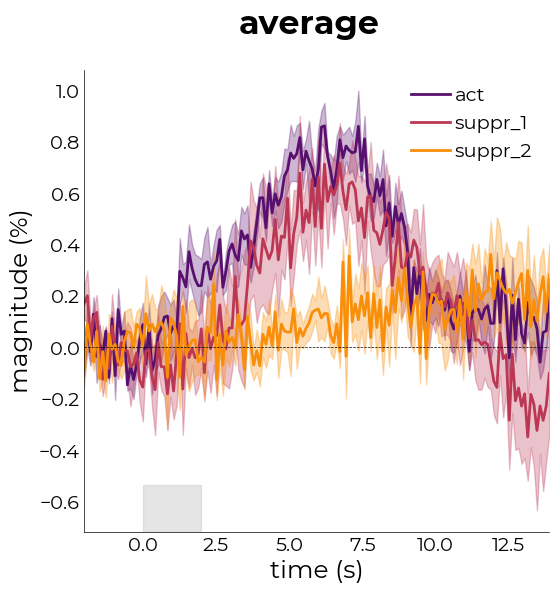

In [13]:
%matplotlib inline
avg_epoch = hr.viz.PlotEpochProfiles(
    avg_ev.groupby(["event_type","epoch","t"]).mean(),
    title="average"
)

### Xin Yu plot averaged over subjects/epochs

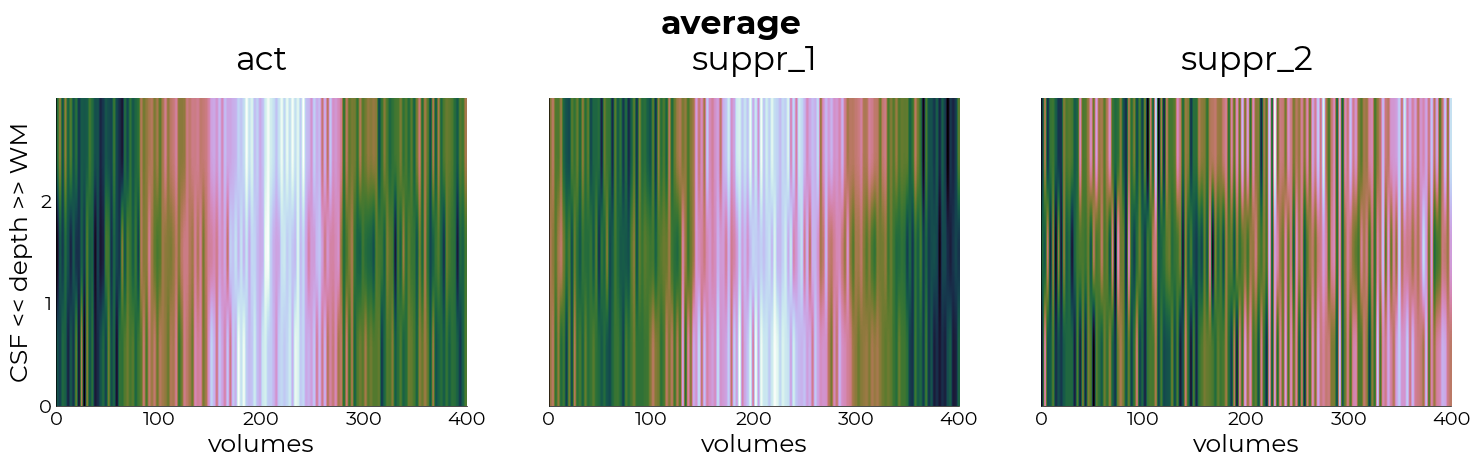

In [14]:
xy_avg = hr.viz.XinYuPlot(
    comp_avg_ev,
    vols=400,
    title="average"
)

## Deconvolve

### Three compartment model

In [15]:
ff = hr.data.make_single_df(h5_obj.df_comps)
oo = hr.data.make_single_df(h5_obj.df_onsets, idx=["subject","run","event_type"])

comp_fit = fitting.NideconvFitter(
    ff,
    oo,
    basis_sets='canonical_hrf_with_time_derivative', #_dispersion',
    # basis_sets="fourier",
    # n_regressors=4,
    TR=0.105,
    interval=[-2,26],
    verbose=True,
    conf_intercept=True,
)

Selected 'canonical_hrf_with_time_derivative'-basis sets (with 2 regressors)
Adding event 'act' to model
Adding event 'suppr_1' to model
Adding event 'suppr_2' to model
Fitting with 'ols' minimization
Done


In [42]:
comp_fit.pars_subjects

magnitude  magnitude_ix      fwhm  \
subject event_type run vox                                      
002     act        1   0     1.209357          1541  4.280306   
                       1     1.308038          1491  4.356117   
                       2     1.329598          1496  4.349337   
        suppr_1    1   0     1.091642          1605  4.192128   
                       1     0.905649          1614  4.181570   
...                               ...           ...       ...   
008     suppr_1    8   1     0.761368          1521  4.310821   
                       2     0.706955          1504  4.337599   
        suppr_2    8   0    -0.315279          1106  3.578886   
                       1    -0.312456          1098  3.522377   
                       2    -0.291818          1240  4.271948   

                                                                     fwhm_obj  \
subject event_type run vox                                                      
002     act        1   0    <linescanning.fitting.FWHM object at 0x7f10f63...   
                       1    <linescanning.fitting.FWHM object at 0x7f10f63...   
                       2    <linescanning.fitting.FWHM object at 0x7f10f62...   
        suppr_1    1   0    <linescanning.fitting.FWHM object at 0x7f10f63...   
                       1    <linescanning.fitting.FWHM object at 0x7f10f63...   
...                                                                       ...   
008     suppr_1    8   1    <linescanning.fitting.FWHM object at 0x7f10f63...   
                       2    <linescanning.fitting.FWHM object at 0x7f10f63...   
        suppr_2    8   0    <linescanning.fitting.FWHM object at 0x7f10f63...   
                       1    <linescanning.fitting.FWHM object at 0x7f10f63...   
                       2    <linescanning.fitting.FWHM object at 0x7f10f63...   

                            time_to_peak  half_rise_time  half_max  \
subject event_type run vox                                           
002     act        1   0         6.09025        4.169022  0.604678   
                       1         5.82775        3.843261  0.654019   
                       2         5.85400        3.872663  0.664799   
        suppr_1    1   0         6.42625        4.582686  0.545821   
                       1         6.47350        4.639276  0.452824   
...                                  ...             ...       ...   
008     suppr_1    8   1         5.98525        4.037684  0.380684   
                       2         5.89600        3.923201  0.353478   
        suppr_2    8   0         3.80650        2.167184 -0.157640   
                       1         3.76450        2.146920 -0.156228   
                       2         4.51000        2.558115 -0.145909   

                            rise_slope  rise_slope_t  positive_area  \
subject event_type run vox                                            
002     act        1   0      0.566423       3.94825       5.093967   
                       1      0.563143       3.73825       5.635211   
                       2      0.576339       3.75925       5.716212   
        suppr_1    1   0      0.581642       4.18450       4.486521   
                       1      0.491818       4.21600       3.711597   
...                                ...           ...            ...   
008     suppr_1    8   1      0.343938       3.86425       3.235646   
                       2      0.310177       3.79075       3.028532   
        suppr_2    8   0     -0.159469       2.15275      -1.124508   
                       1     -0.159825       2.13700      -1.096502   
                       2     -0.124333       2.53600      -1.242743   

                            undershoot  
subject event_type run vox              
002     act        1   0      1.734292  
                       1      1.934969  
                       2      1.962387  
        suppr_1    1   0      1.471896  
                       1      1.207976  
...   

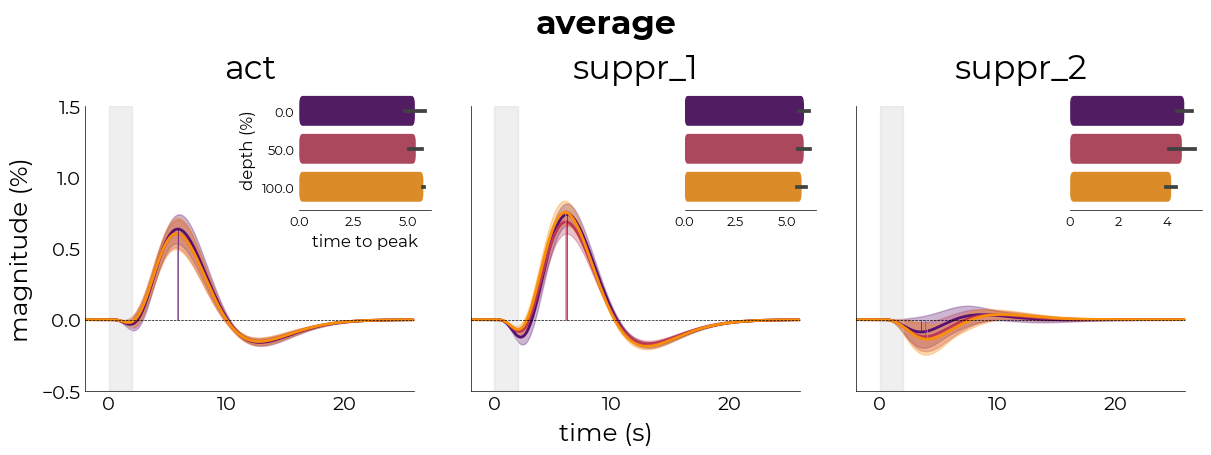

In [50]:
dec_comp = hr.viz.PlotDeconvProfiles(
    comp_fit,
    title="average",
    inset_kwargs={
        "fancy": True,
        # "fancy_denom": 3,
        "sns_offset": 3,
        # "add_points": True,
    },
    err="sem"
)

In [51]:
dec_comp.ev_pars

magnitude  magnitude_ix      fwhm  time_to_peak  \
subject event_type vox                                                    
002     suppr_2    0    -0.162382   1226.857143  3.723085      4.441000   
                   1    -0.103469   1159.714286  3.556526      4.088500   
                   2    -0.150673   1143.714286  3.432113      4.004500   
008     suppr_2    0    -0.052863   1343.500000  4.055265      5.053375   
                   1    -0.072986   1372.375000  3.935002      5.204969   
                   2    -0.113584   1219.375000  3.568787      4.401719   

                        half_rise_time  half_max  rise_slope  rise_slope_t  \
subject event_type vox                                                       
002     suppr_2    0          2.745128 -0.081191   -0.105657      2.611000   
                   1          2.431951 -0.051734   -0.044224      2.416000   
                   2          2.406848 -0.075337   -0.070044      2.371750   
008     suppr_2    0          3.219226 -0.026432   -0.029145      3.089875   
                   1          3.427036 -0.036493   -0.031479      3.232281   
                   2          2.745630 -0.056792   -0.054317      2.669219   

                        positive_area  undershoot  
subject event_type vox                             
002     suppr_2    0        -0.523827    0.617197  
                   1        -0.434482    0.730710  
                   2        -0.584160    0.694328  
008     suppr_2    0        -0.157782    0.411530  
                   1        -0.265967    0.292741  
                   2        -0.435375    0.365106

### Single-subject ribbon profiles

In [120]:
models = {}

for key,val in h5_obj.dict_ribbon.items():

    # parse into single dataframe
    ff = hr.data.make_single_df(val.copy())
    oo = hr.data.make_single_df(utils.select_from_df(h5_obj.df_onsets, expression=f"subject = {key.split('-')[-1]}"), idx=["subject","run","event_type"])
    
    # fit
    can_fit = fitting.NideconvFitter(
        ff,
        oo,
        basis_sets='canonical_hrf_with_time_derivative', #_dispersion',
        # basis_sets="fourier",
        # n_regressors=4,
        TR=0.105,
        interval=[-2,26],
        verbose=True,
        conf_intercept=True,
    )

    can_fit.timecourses_condition()

    models[key] = can_fit

Selected 'canonical_hrf_with_time_derivative'-basis sets (with 2 regressors)
Adding event 'act' to model
Adding event 'suppr_1' to model
Adding event 'suppr_2' to model
Fitting with 'ols' minimization
Done
Selected 'canonical_hrf_with_time_derivative'-basis sets (with 2 regressors)
Adding event 'act' to model
Adding event 'suppr_1' to model
Adding event 'suppr_2' to model
Fitting with 'ols' minimization
Done


In [123]:
models

{'sub-002': <linescanning.fitting.NideconvFitter at 0x7f1421e14730>,
 'sub-008': <linescanning.fitting.NideconvFitter at 0x7f147f973d30>}

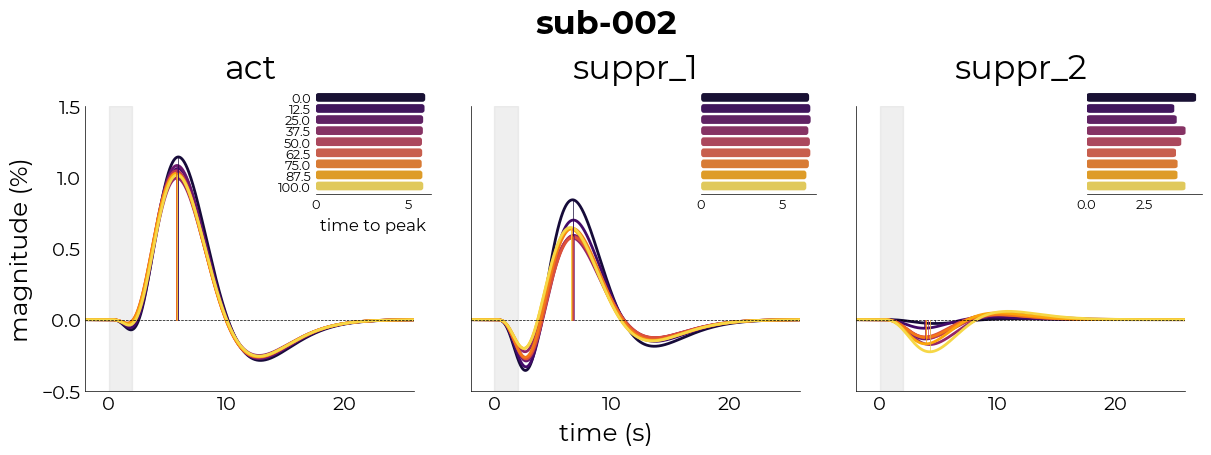

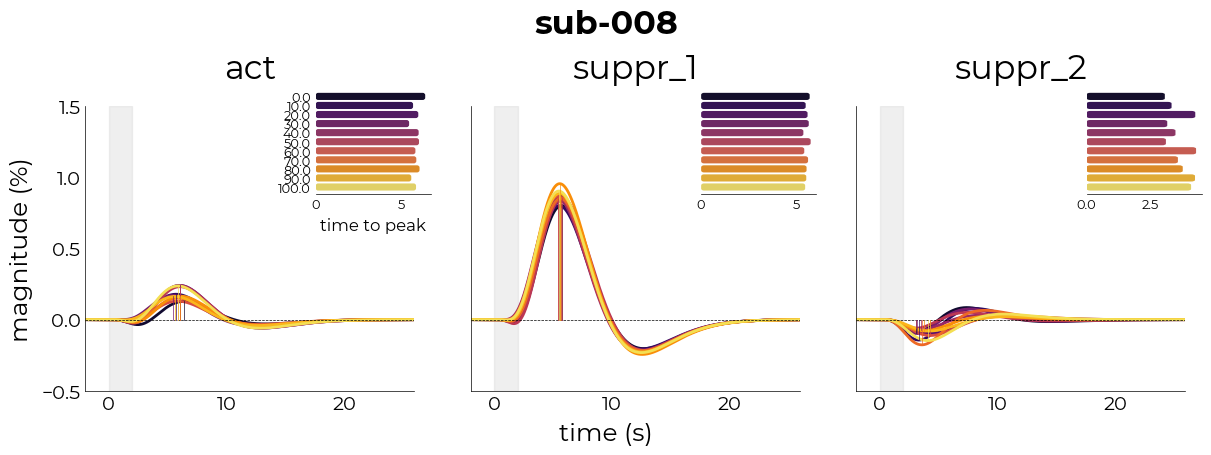

In [131]:
for key in list(models.keys()):
    dec_profs = hr.viz.PlotDeconvProfiles(
        models[key],
        title=key
    )